# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions import cosmic_val
from functions.graph_tools import *
from functions.data_handling import data_augmentation
from models.muse import *
from functions import cosmic_val
from functions import data_handling as dh
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

# set seed
# np.random.seed(15)
# torch.manual_seed(15)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed/Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
L_ONE = 128
LATENT_DIM = 4
TOLERANCE = 1e-10
CONSTRAINT = 'identity'
CRITERION = nn.MSELoss()
REFIT = False
REFIT_PENALTY = 1e-3

In [6]:
losses_train = []
signatures = []
iterations = 30


for i in tqdm(range(iterations)):
    # Train-test split (here it makes sense, we are working with AE)

    augmented_data = data_augmentation(X = data, augmentation = 3)


    muse_model = HybridAutoencoder(input_dim = data.shape[0], #96
                                   l_1 = L_ONE,
                                   latent_dim = LATENT_DIM,
                                   refit = REFIT,
                                   refit_penalty = REFIT_PENALTY,
                                   constraint= CONSTRAINT)
    # Training MUSE

    muse_error, muse_signatures, muse_exposures, muse_train_loss, muse_val_loss = train_model_for_extraction(model = muse_model,
                                                                                            X_aug_multi_scaled = augmented_data.T,
                                                                                            X_scaled = data.T,
                                                                                            signatures = LATENT_DIM,
                                                                                            epochs = 1000,
                                                                                            batch_size = 64,
                                                                                            save_to = 'muse_test',
                                                                                            iteration = 1,
                                                                                            patience = 30)

    print("SHAPE OF SIGNATURES: ", muse_signatures.shape)
    print("SHAPE OF EXPOSURES: ", muse_exposures.shape)


    # Calculating signatures and exposures for NMF
    diagonals_muse = muse_signatures.sum(axis=0)
    muse_exposures = muse_exposures.T @ np.diag(diagonals_muse)
    muse_signatures = (muse_signatures) @ np.diag(1 / diagonals_muse)

    
    losses_train.append(muse_error)
    signatures.append(muse_signatures)



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/1000 - Training Loss: -4337405.945467 - Validation Loss: -37085928.000000


/home/nicovis/Projects/DeepLearningProject/models/muse.py:363: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
100%|████████

Early stopping at epoch 109
SHAPE OF SIGNATURES:  (96, 4)
SHAPE OF EXPOSURES:  (4, 523)


In [7]:
print("Losses train: ", np.mean(losses_train))

Losses train:  5734662.459140761


In [8]:
all_signatures = np.hstack(signatures)

In [9]:
print(all_signatures.shape)

(96, 4)


In [10]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [11]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic)

In [12]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted    True  Similarity
0          0    SBS3    0.873883
1          1  SBS40c    0.883711
2          2  SBS40a    0.826377
3          3    SBS5    0.885940

Mean similarity of the matched signatures:  0.8674778882952754


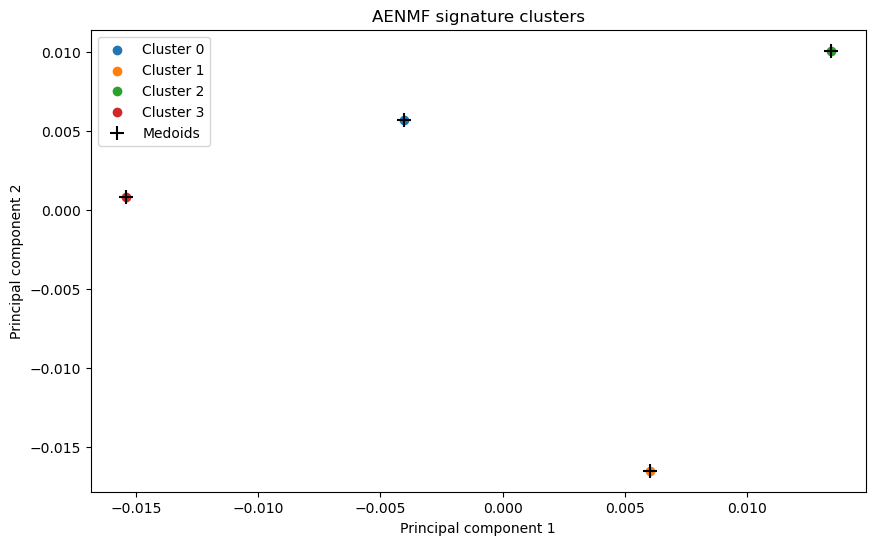

In [13]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "AENMF signature clusters")

In [14]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

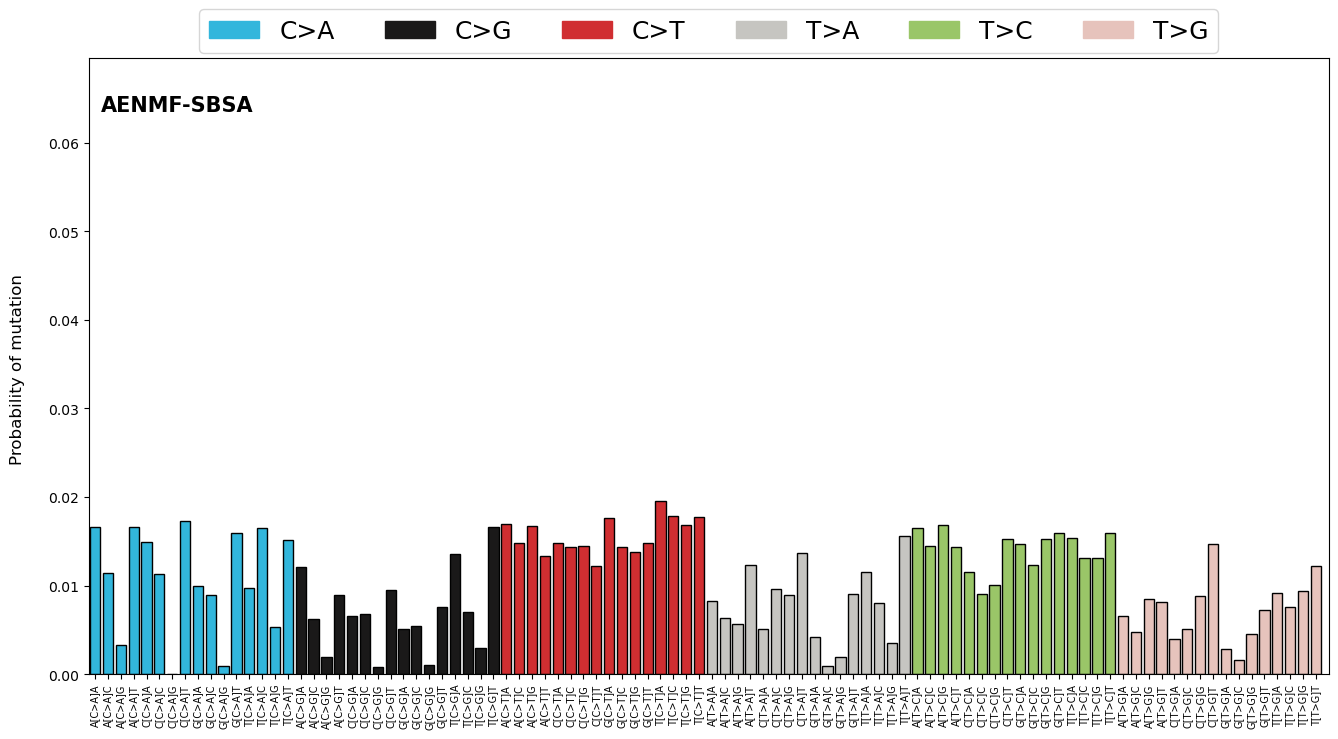

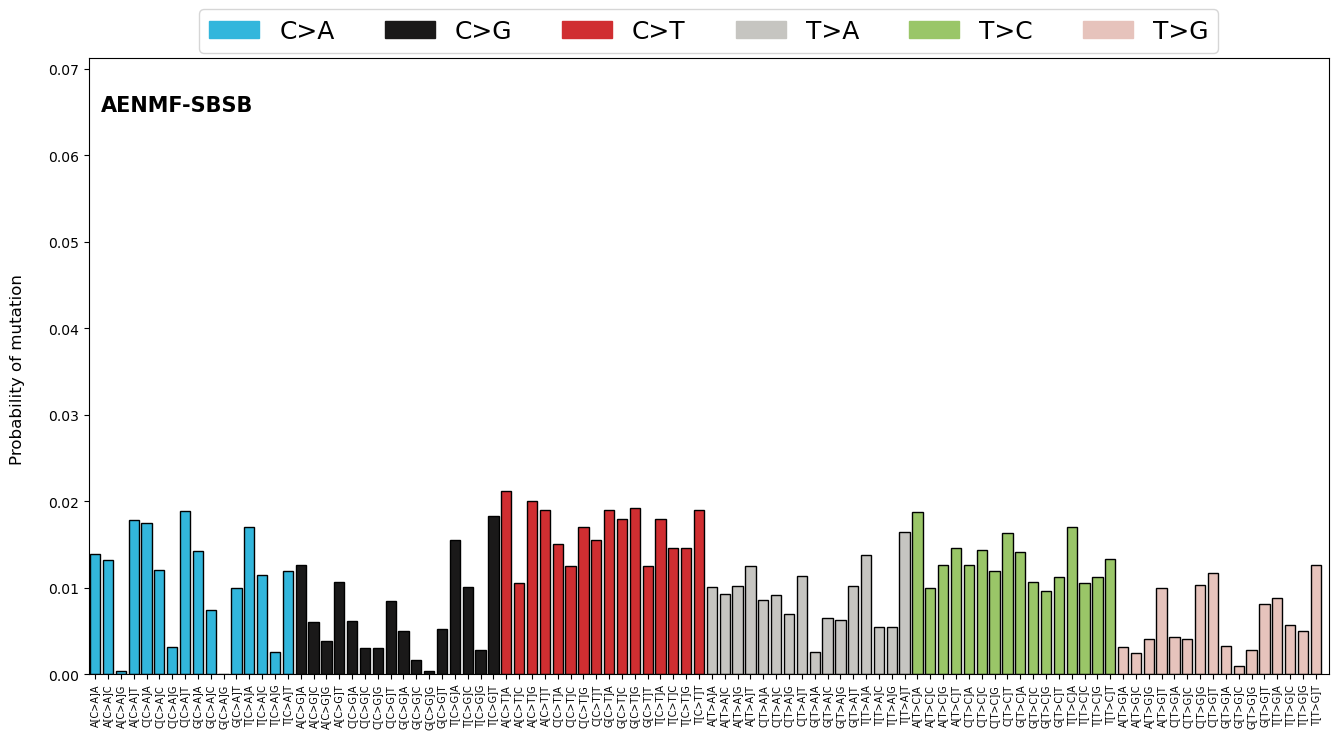

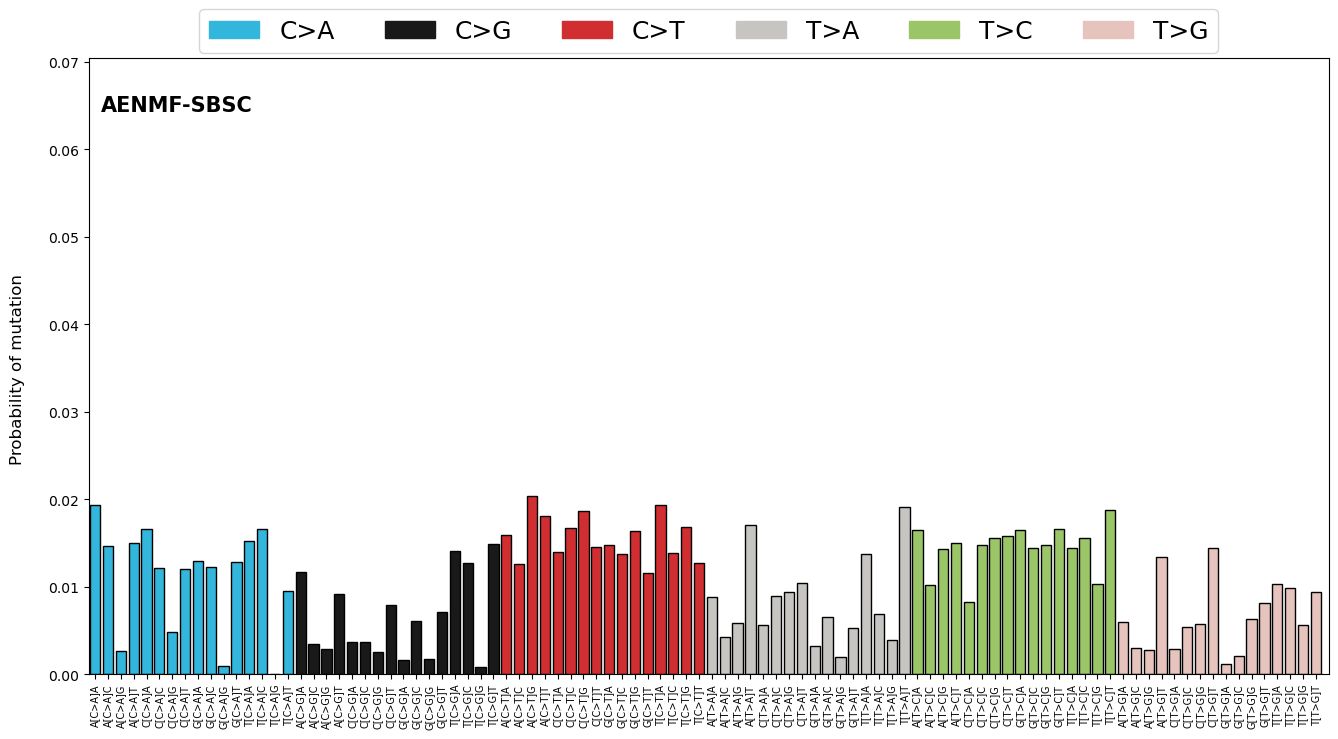

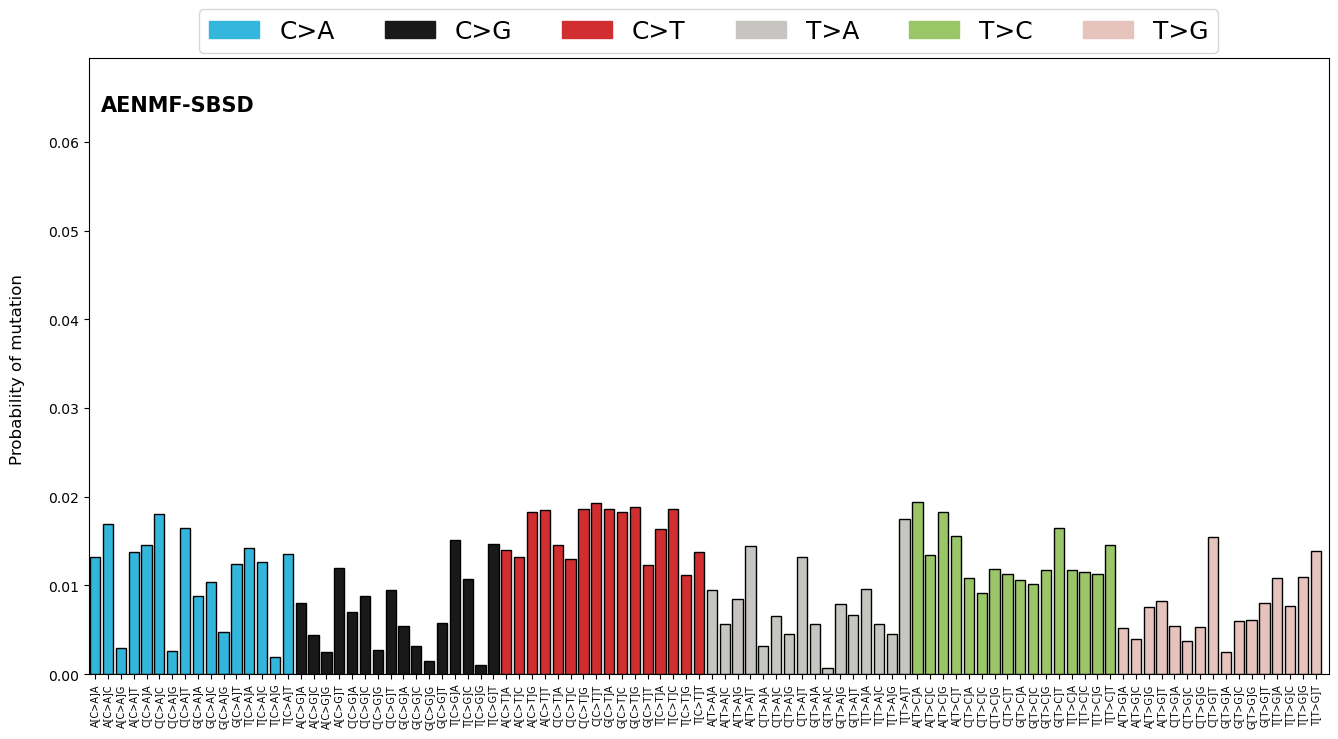

In [15]:
plot_signature(df_consensus, "AENMF consensus signatures")